In [209]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-paper')

In [23]:
path1 = "./data/0512_data.xlsx"
path2 = "./data/0513_data.xlsx"
df12 = pd.read_excel(path1, index_col=0)  
df13 = pd.read_excel(path2, index_col=0) 

df12.head()

,strike,price,maturity,rate,sigma,kappa,theta,volvol,rho,Heston price,Implied Vol,delta,gamma,greek_theta
0,2400,1737.599854,3.605749,0.029094,0.010018,0.775347,0.01,0.047384,-2.066950e-08,1914.511397,0.246016,-1.244224,-1.296648e+10,353.490471
1,2400,1680.099854,2.609172,0.027971,0.010018,0.775347,0.01,0.047384,-2.066950e-08,1814.285281,0.232394,-1.931821,-1.060894e+10,669.490520
2,2600,1523.000000,2.609172,0.027971,0.010018,0.775347,0.01,0.047384,-2.066950e-08,1634.203588,0.214416,-1.276966,-3.654191e+10,537.733790
3,2600,1584.399902,3.605749,0.029094,0.010018,0.775347,0.01,0.047384,-2.066950e-08,1738.868345,0.224083,-1.276966,-7.072627e+09,289.380213
4,2800,1437.899902,3.605749,0.029094,0.010018,0.775347,0.01,0.047384,-2.066950e-08,1566.554968,0.205989,-0.982282,-2.239665e+10,244.227994


In [110]:
df13.head()

,strike,price,maturity,rate,sigma,kappa,theta,volvol,rho,Heston price,Implied Vol,delta,gamma,greek_theta
0,2200,1942.300049,2.606434,0.027967,0.128008,1.246246,0.01,0.089732,-0.99999,2012.804890,0.274221,-4.780438,-4.479330e+10,665.790592
1,2200,1969.599976,3.603012,0.029092,0.128008,1.246246,0.01,0.089732,-0.99999,2110.751996,0.286758,-4.191069,-5.422347e+10,447.724036
2,2400,1779.500000,2.606434,0.027967,0.128008,1.246246,0.01,0.089732,-0.99999,1838.442250,0.261279,-3.274273,-5.893856e+10,421.464370
3,2400,1816.699951,3.603012,0.029092,0.128008,1.246246,0.01,0.089732,-0.99999,1940.432539,0.267028,-3.339758,-1.414525e+10,287.153708
4,2600,1620.500000,2.606434,0.027967,0.128008,1.246246,0.01,0.089732,-0.99999,1666.788437,0.248830,-3.274273,-2.357542e+09,296.321671


### Test the first option from 05/12

In [36]:
r = 0.029094222                                     # drift
rho = -2.06695E-08                                  # correlation
kappa = 0.775347046                               
theta = df12['theta'][0]                          
sigma = 0.047384121                                # Vol of Vol
T = 3.605749487                                     # Maturity
K = 2400                                            # Stike  
v0 = 0.010018499                                   # spot variance
S0 = 4017.50                                                             

0.009905905184065934

In [96]:
def HestonModelMC(N, paths, T, S0,  v0, 
                  mu, rho, kappa, theta, sigma):
    # Set dt
    N = int(T*N)
    dt = T/(N-1)
    dt_sq = np.sqrt(dt)

    assert(2*kappa * theta > sigma**2)       # test CIR Feller condition
    
    W_S = []     # declaration Brownian motion for S
    W_v = []     # declaration Brownian motion for v 
    
    # Initialize
    v_T = np.zeros(paths)   # values of v at T
    S_T = np.zeros(paths)   # values of S at T 
    v = np.zeros(N)
    S = np.zeros(N)
    MCSPaths = []
    MCVPaths = []
    
    for path in range(paths):
        # Generate W1 and W2 Brownian Motion
        W_2 = np.random.normal(loc=0, scale=1, size=N-1 )
        W_1 = rho * W_2 + np.sqrt(1-rho**2) * np.random.normal(loc=0, scale=1, size=N-1 )
        W_S = W_2
        W_v = W_1
        S[0] = S0           # stock at 0
        v[0] = v0           # variance at 0   
        singleSPath = [S0]
        singleVPath = [v0]
#         print(path)
        
        for t in range(0,N-1):
#             print("i: ", t)
#             print(S[t+1])
            S[t+1] = S[t] *  np.exp( (mu - 0.5*v[t])*dt + np.sqrt(v[t]) * dt_sq * W_S[t] )
            v[t+1] = np.absolute( v[t] + kappa*(theta - v[t])*dt + sigma * np.sqrt(v[t]) * dt_sq * W_v[t] )
            singleSPath.append(S[t+1])
            singleVPath.append(v[t+1])
        
        S_T[path] = S[N-1]
        v_T[path] = v[N-1]
        MCSPaths.append(singleSPath)
        MCVPaths.append(singleVPath)
        
    return np.asarray(S_T), np.asarray(v_T), MCSPaths, MCVPaths

In [130]:
%%time
S, v, MCSPaths, MCVPaths = HestonModelMC(N=365, paths=10000, T=T, S0=S0, v0=v0, mu=r, rho=rho, kappa=kappa, theta=theta, sigma=sigma  )
DiscountedPayoff = np.exp(-r*T) * np.maximum(S-K,0) 
C = np.mean(DiscountedPayoff)
V = np.mean(v)
print("Heston MC call price: ", C)
print("MC mean volatility: ", V)
print("-----------------------------------")

Heston MC call price:  302.7913202529201
MC mean volatility:  0.11602701803377058
-----------------------------------
CPU times: user 2.97 s, sys: 48 ms, total: 3.01 s
Wall time: 3.09 s


### Simulated Price Paths

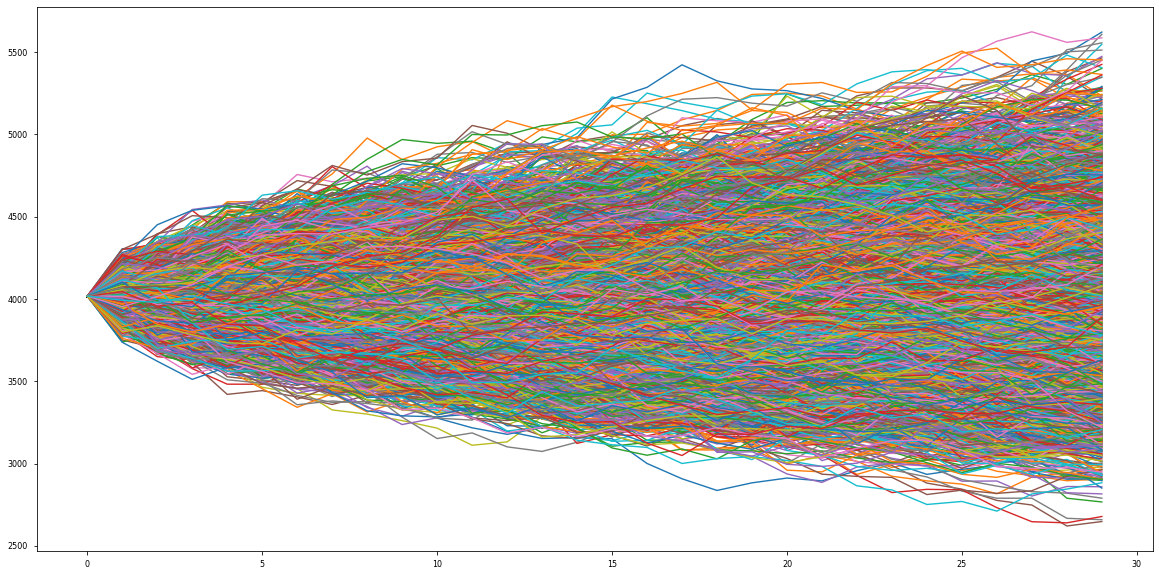

In [194]:
plt.figure(figsize=(20,10))
# Plot the set of generated sample paths
for price_path in MCSPaths:
    plt.plot(price_path)
plt.show()

### Simulated Volatility Paths

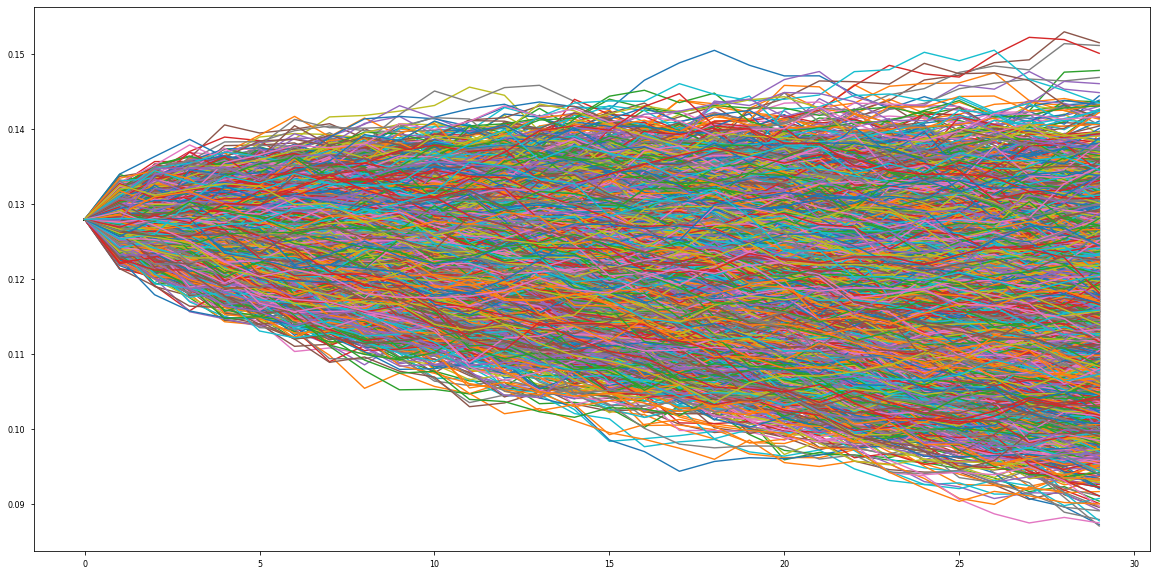

In [195]:
plt.figure(figsize=(20,10))
# Plot the set of generated sample paths
for vol_path in MCVPaths:
    plt.plot(vol_path)
plt.show()

In [103]:
result = [[df12['strike'][0] , C, df12['Heston price'][0]]]

dfResult1 = pd.DataFrame(result, columns = ['Option Strike', 'MC Price', 'Heston Price'])
dfResult1

,Option Strike,MC Price,Heston Price
0,2400,1860.996104,1914.511397


In [104]:
for i in range(len(df12)):
    r = df12['rate'][i]                                   # drift
    rho = df12['rho'][i]                                  # correlation
    kappa = df12['kappa'][i]                                 
    theta = df12['theta'][i]                          
    sigma = df12['volvol'][i]                             # Vol of Vol
    T = df12['maturity'][i]                               # Maturity
    K = df12['strike'][i]                                 # Stike  
    v0 = df12['sigma'][i]                                 # spot variance
    S0 = 4017.50                                                     
    S, v, MCSPaths, MCVPaths = HestonModelMC(N=365, paths=10000, T=T, S0=S0, v0=v0, mu=r, rho=rho, kappa=kappa, theta=theta, sigma=sigma  )
    DiscountedPayoff = np.exp(-r*T) * np.maximum(S-K,0) 
    C = np.mean(DiscountedPayoff)
    result = [df12['strike'][i] , C, df12['Heston price'][i]]
    dfResult1.loc[len(dfResult1)] = result 

dfResult1

,Option Strike,MC Price,Heston Price
0,2400.0,1860.996104,1914.511397
1,2400.0,1866.281174,1914.511397
2,2400.0,1788.310913,1814.285281
3,2600.0,1604.294855,1634.203588
4,2600.0,1682.951234,1738.868345
...,...,...,...
171,3775.0,329.660224,439.071669
172,3775.0,446.340044,579.294575
173,3775.0,344.384272,454.035171
174,3775.0,299.999229,386.049679


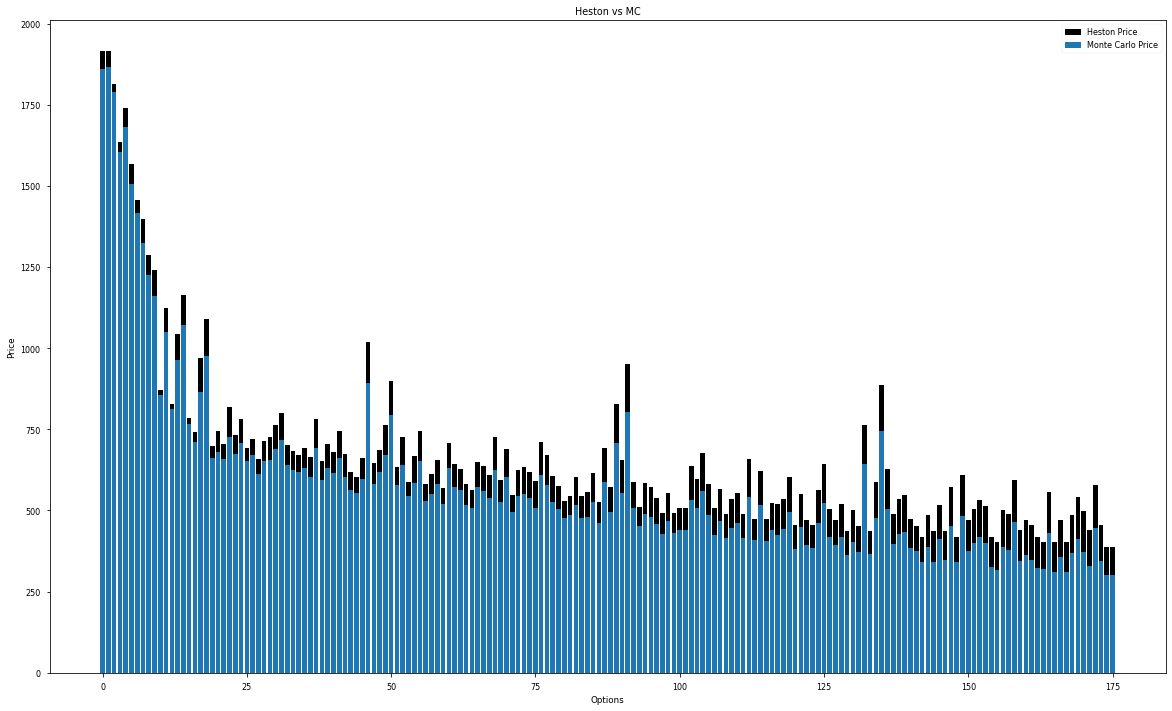

In [199]:
# dfResult1[['MC Price', 'Heston Price']].plot.line()
# plt.plot(dfResult1.index, dfResult1[['MC Price', 'Heston Price']])
fig, ax = plt.subplots(figsize=(20,12))

ax.bar(dfResult1.index, dfResult1['Heston Price'], label='Heston Price', color='black')
ax.bar(dfResult1.index, dfResult1['MC Price'], label='Monte Carlo Price', color='tab:blue')


ax.set_ylabel('Price')
ax.set_xlabel('Options')
ax.set_title('Heston vs MC')
ax.legend()

plt.show()

In [105]:
for i in range(len(df13)):
    r = df13['rate'][i]                                   # drift
    rho = df13['rho'][i]                                  # correlation
    kappa = df13['kappa'][i]                                 
    theta = df13['theta'][i]                          
    sigma = df13['volvol'][i]                             # Vol of Vol
    T = df13['maturity'][i]                               # Maturity
    K = df13['strike'][i]                                 # Stike  
    v0 = df13['sigma'][i]                                 # spot variance
    S0 = 4017.50                                                     
    S, v, MCSPaths, MCVPaths = HestonModelMC(N=365, paths=10000, T=T, S0=S0, v0=v0, mu=r, rho=rho, kappa=kappa, theta=theta, sigma=sigma  )
    DiscountedPayoff = np.exp(-r*T) * np.maximum(S-K,0) 
    C = np.mean(DiscountedPayoff)
    if i == 0:
        result = [[df13['strike'][i] , C, df13['Heston price'][i]]]
        dfResult2 = pd.DataFrame(result, columns = ['Option Strike', 'MC Price', 'Heston Price'])
    else:
        result = [df13['strike'][i] , C, df13['Heston price'][i]]
        dfResult2.loc[len(dfResult2)] = result 

dfResult2

,Option Strike,MC Price,Heston Price
0,2200.0,1986.101369,2012.804890
1,2200.0,2058.720021,2110.751996
2,2400.0,1813.546846,1838.442250
3,2400.0,1876.304790,1940.432539
4,2600.0,1654.616858,1666.788437
...,...,...,...
201,3775.0,664.434663,614.007159
202,3775.0,598.668148,546.296129
203,3775.0,577.226341,527.916547
204,3775.0,599.039520,560.259294


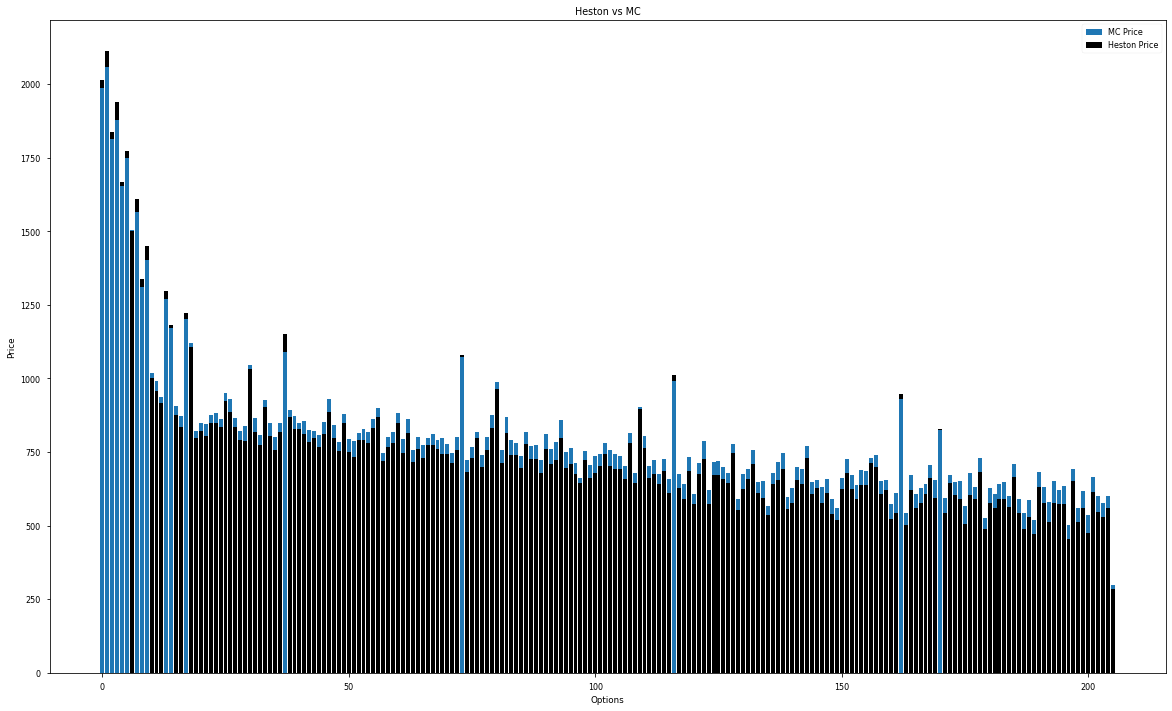

In [197]:
plt.figure(figsize=(20,12))

mask1 = ma.where(dfResult2['MC Price']>=dfResult2['Heston Price'])
mask2 = ma.where(dfResult2['MC Price']<=dfResult2['Heston Price'])

# width = 0.5
X = np.arange(len(dfResult2.index))
p1 = plt.bar(X[mask1], dfResult2['MC Price'].to_numpy()[mask1], color='tab:blue', alpha=1, log=False)
p2 = plt.bar(X, dfResult2['Heston Price'], color='black', alpha=1, edgecolor='none', log=False)
p3 = plt.bar(X[mask2], dfResult2['MC Price'].to_numpy()[mask2], color='tab:blue', alpha=1, log=False)

plt.xlabel('Options')
plt.ylabel('Price')
plt.title('Heston vs MC')
plt.legend(['MC Price', 'Heston Price'], loc='upper right')

plt.show()